In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.4 is required in this notebook
# Earlier 2.x versions will mostly work the same, but with a few bugs
import tensorflow as tf
from tensorflow import keras

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Custom Loss Function

In [3]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full,X_test,y_train_full,y_test = train_test_split(housing.data,
                                                           housing.target.reshape(-1,1),random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scalled = scaler.fit_transform(X_train)
X_valid_scalled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)


In [4]:
y_test

array([[0.477  ],
       [0.458  ],
       [5.00001],
       ...,
       [1.177  ],
       [2.631  ],
       [4.815  ]])

In [5]:
def huber_fn(y_true,y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) <1
    squared_loss = tf.square(error) /2 
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error,squared_loss,linear_loss)

Saving figure huber_loss.png


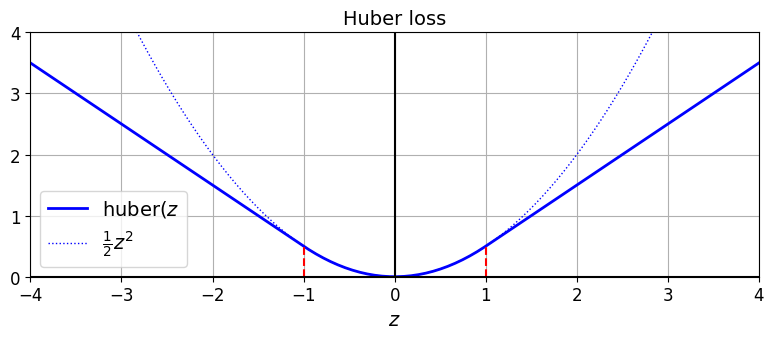

In [6]:
plt.figure(figsize=(8,3.5))
z = np.linspace(-4,4,200)
plt.plot(z,huber_fn(0,z),"b-",linewidth=2,label="huber($z$")
plt.plot(z,z**2 / 2, "b:",linewidth=1,label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
save_fig("huber_loss.png")
plt.show()

In [7]:
input_shape = X_train.shape[1:] # 8
model_1 = keras.models.Sequential([
    keras.layers.Dense(30,activation="selu",kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1)
])

In [8]:
model_1.compile(loss=huber_fn,optimizer="nadam",metrics=["mse"])

In [9]:
model_1.fit(X_train,y_train,epochs=10,validation_data=[X_valid,y_valid])

Epoch 1/10
363/363 [==============================] - 2s 2ms/step - loss: 7.8809 - mse: 804.8727 - val_loss: 4.5257 - val_mse: 41.7822
Epoch 2/10
363/363 [==============================] - 0s 1ms/step - loss: 2.8286 - mse: 20.4366 - val_loss: 0.8132 - val_mse: 9.5738
Epoch 3/10
363/363 [==============================] - 0s 1ms/step - loss: 2.4984 - mse: 16.6541 - val_loss: 1.9190 - val_mse: 10.1822
Epoch 4/10
363/363 [==============================] - 0s 1ms/step - loss: 2.2900 - mse: 13.9849 - val_loss: 1.5336 - val_mse: 7.3149
Epoch 5/10
363/363 [==============================] - 0s 1ms/step - loss: 2.1483 - mse: 12.8204 - val_loss: 1.0164 - val_mse: 4.5552
Epoch 6/10
363/363 [==============================] - 0s 1ms/step - loss: 1.9771 - mse: 11.3043 - val_loss: 1.4466 - val_mse: 9.9283
Epoch 7/10
363/363 [==============================] - 0s 1ms/step - loss: 1.8751 - mse: 10.0130 - val_loss: 0.8779 - val_mse: 5.7729
Epoch 8/10
363/363 [==============================] - 0s 1ms/step 

# Saving / Loading models with custom objects

In [10]:
# saving the custome model
model_1.save("model_1_with_custom_loss.h5")

In [11]:
model_1_load = keras.models.load_model("model_1_with_custom_loss.h5",
                                       custom_objects={"huber_fn":huber_fn})

In [13]:
model_1_load.fit(X_train_scalled,y_train,epochs=2,
                 validation_data=[X_valid_scalled,y_valid])

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2166 - mse: 0.5349 - val_loss: 0.2282 - val_mse: 2.1640
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2097 - mse: 0.5034 - val_loss: 0.2114 - val_mse: 1.1203


1. Create the hubber function with the spesific theresold

In [21]:
def create_huber(thereshold=1.0):
    def huber_fn(y_true,y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < thereshold
        squared_loss = tf.square(error) /2
        linear_loss = thereshold * tf.abs(error) - thereshold ** 2 / 2
        return tf.where(is_small_error,squared_loss,linear_loss)
    return huber_fn

custom object (theresold isnt save on save models) must be eksplisit on the load models

In [23]:
input_shape = X_train.shape[1:]

model_2 = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])



In [24]:
model_2.compile(loss=create_huber(2.0),optimizer="nadam",metrics=["mae"])


In [25]:
model_2.fit(X_train_scalled,y_train,epochs=2,
            validation_data=[X_valid_scalled,y_valid])

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.7346 - mae: 0.9068 - val_loss: 0.2382 - val_mae: 0.5066
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2383 - mae: 0.5101 - val_loss: 0.2425 - val_mae: 0.4972


In [26]:
model_2.save("model_2_with_custom_loss_thershold.h5")


In [27]:
model_2 = keras.models.load_model("model_2_with_custom_loss_thershold.h5",
                                  custom_objects={"huber_fn":create_huber(2.0)})

untuk menghindari custom objects by parameter bisa digunakan class dengan ditambahkan get config dari parent class keras.losses.loss

In [28]:
class HuberLoss(keras.losses.Loss):
    def __init__(self,threshold=1.0,**kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self,y_true,y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config=super().get_config()
        return {**base_config,"threshold":self.threshold}

In [29]:
model_3 = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [30]:
model_3.compile(loss=HuberLoss(2.0),optimizer="nadam",
                metrics=["mae"])

In [31]:
model_3.fit(X_train_scalled,y_train,epochs=2,
            validation_data=[X_valid,y_valid])

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.8784 - mae: 0.9922 - val_loss: 771.9103 - val_mae: 386.9552
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2588 - mae: 0.5336 - val_loss: 626.2947 - val_mae: 314.1473


In [32]:
model_3.save("model_3_with_custom_loss_class.h5")

In [34]:
model_3 = keras.models.load_model("model_3_with_custom_loss_class.h5",
                                  custom_objects={"HuberLoss":HuberLoss})

In [35]:
model_3.fit(X_train_scalled,y_train,epochs=2,
            validation_data=[X_valid,y_valid])

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.2376 - mae: 0.5089 - val_loss: 600.0468 - val_mae: 301.0234
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2259 - mae: 0.4958 - val_loss: 560.9318 - val_mae: 281.4659


In [37]:
model_3.loss.threshold

2.0

# Other Custom Functions

In [39]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [38]:
def my_softplus(z): # return value is just tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [40]:
layer = keras.layers.Dense(1,activation=my_softplus,
                           kernel_initializer = my_glorot_initializer,
                           kernel_regularizer= my_l1_regularizer,
                           kernel_constraint = my_positive_weights)

In [41]:
model_4 = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [42]:
model_4.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [43]:
model_4.fit(X_train_scalled, y_train, epochs=2,
          validation_data=(X_valid_scalled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 1.8591 - mae: 0.9729 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.6428 - mae: 0.5467 - val_loss: 2.8218 - val_mae: 0.5481


In [44]:
model_4.save("my_model_with_many_custom_parts.h5")

In [45]:
model_4 = keras.models.load_model("my_model_with_many_custom_parts.h5",
                                  custom_objects={
                                        "my_l1_regularizer": my_l1_regularizer,
                                        "my_positive_weights": my_positive_weights,
                                        "my_glorot_initializer": my_glorot_initializer,
                                        "my_softplus": my_softplus,
                                  })

In [47]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self,factor):
        self.factor = factor
    def __call__(self,weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor":self.factor}

In [51]:
model_5 = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [52]:
model_5.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [54]:
model_5.fit(X_train_scalled, y_train, epochs=2,
          validation_data=(X_valid_scalled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 1.9970 - mae: 0.9151 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.7469 - mae: 0.5270 - val_loss: inf - val_mae: inf


In [55]:
model_5.save("my_model_with_many_custom_parts.h5")

In [56]:
model_5 = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })